# USESO 2023 Climate Dynamics talk 
Yuchen Li (June 28 2023) yuchenli713@gmail.com

**About:** these scripts were used to generate figures in my talk on some topics in climate dynamics. The SST dataset used is the NOAA OISST dataset, accessed through the cloud using opendap. Some of the figures require installation of cartopy, a map-related package for Python. 

**Credits:** concepts for figures/visuals were original; code was mostly written by GPT-4 (try it!). The Lorenz system animation was modified from https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/.



# SST animation 
this generates a gif of the global SST anomaly from 1980 something to present day. 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import imageio

# Open the dataset
dataset = xr.open_dataset('http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCDC/.OISST/.version2p1/.AVHRR_monthly/.anom_c9120/dods', decode_times=False)

# Extract SST anomaly data
sst_anom = dataset["anom_c9120"]


# Generate each frame for the animation
frames_path = []
for i in range(len(sst_anom.T)):
    plt.figure(figsize=(10, 6))
    sst_anom.isel(T=i).plot(vmin=-3, vmax=3, cmap='RdBu_r')
    plt.title(f"Month {i+1}")
    temp_path = f"./temp_plot_{i}.png"
    frames_path.append(temp_path)
    plt.savefig(temp_path)
    plt.close()

# Create GIF animation
with imageio.get_writer('sst_anomaly.gif', mode='I') as writer:
    for frame_path in frames_path:
        image = imageio.imread(frame_path)
        writer.append_data(image)

# Remove temporary files
for frame_path in frames_path:
    os.remove(frame_path)


KeyError: "'X' is not a valid dimension or coordinate"

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import os

# Open the dataset
dataset = xr.open_dataset('http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCDC/.OISST/.version2p1/.AVHRR_monthly/.anom_c9120/dods', 
                          decode_cf=False)

# Convert time values to datetime objects
dataset["T"] = cftime.num2date(dataset["T"], 'months since 1960-01-01', '360_day')

# Extract SST anomaly data
sst_anom = dataset["anom_c9120"]

# Define region of interest
sst_anom = sst_anom.sel(lon=slice(180, 290), lat=slice(-30, 30))

# Create a directory to save the frames
os.makedirs("frames", exist_ok=True)

# Loop over each time point to generate the plots
for i in range(len(sst_anom["T"])):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    sst_anom.isel(T=i).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False)
    ax.set_extent([-180, -70, -30, 30], crs=ccrs.PlateCarree())
    plt.savefig(f"frames/sst_anomaly_{i}.png")
    plt.close(fig)  # Close the figure to save memory


# Calculating Nino3.4
This calculates an El Niño index (Nino3.4) based on monthly averaged SST anomaly in equatorial pacific. You need to run each block in this section in order from the top. 

(*note: technically, area averages should be computed using weights proportional to the cosine of the latitude; however since the Nino3.4 region is close to the equator, cos(phi) ~ 1 and this effect can be ignored with minimal error*)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime

# Open the dataset and calculate the sst anomaly
sst_dataset = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.mon.mean.nc')

# due to 500 MB queue limit set by xarray, load the data in chunks
sst_chunks = []

# Loop over the years
start_year,end_year = 1981,2023
print('Retrieving SST from dataset:')
for year in range(start_year, end_year+1):
    # Load a year's worth of data
    chunk = sst_dataset.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    sst = chunk['sst'].load()
    
    # Add the chunks to the list
    sst_chunks.append(sst)

    print(f'{year} done.', end=" ")


Retrieving SST from dataset:
1981 done. 1982 done. 1983 done. 1984 done. 1985 done. 1986 done. 1987 done. 1988 done. 1989 done. 1990 done. 1991 done. 1992 done. 1993 done. 1994 done. 1995 done. 1996 done. 1997 done. 1998 done. 1999 done. 2000 done. 2001 done. 2002 done. 2003 done. 2004 done. 2005 done. 2006 done. 2007 done. 2008 done. 2009 done. 2010 done. 2011 done. 2012 done. 2013 done. 2014 done. 2015 done. 2016 done. 2017 done. 2018 done. 2019 done. 2020 done. 2021 done. 2022 done. 2023 done. 

In [2]:
### Calculate the Nino3.4 index and ssta
# Concatenate the chunks along the time dimension
sst = xr.concat(sst_chunks, dim='time')

# compute monthly sst anomaly (ssta). groupby month allows for removal of seasonal cycle
ssta = sst.groupby('time.month') - sst.groupby('time.month').mean('time')

# Compute Nino3.4
nino34_index = ssta.sel(lat=slice(-5, 5), lon=slice(360-170, 360-120)).mean(dim=['lat', 'lon'])
nino34_index_unsmooth = nino34_index # keep a version of the unsmoothed version
nino34_index = nino34_index.rolling(time=5, center=True).mean()

# uncomment to save this locally
# nino34_index.to_netcdf('nino34_index.nc')

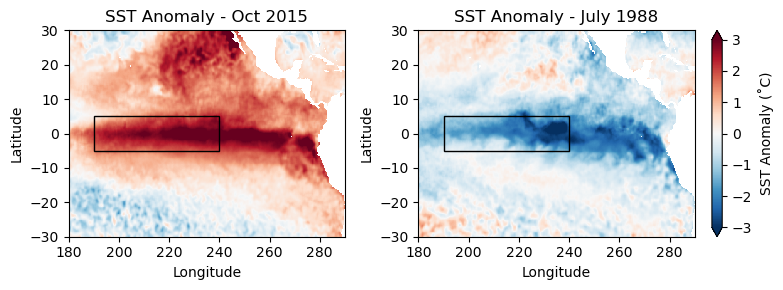

In [15]:
### plot illustration of nino3.4 region during both phases
import matplotlib.patches as patches
from matplotlib import gridspec

# Select the data for July 2015 and July 1988 and localize to Eq. Pcf
sst_anom_2015 = ssta.sel(time='2015-10-01', lon=slice(180, 290), lat=slice(-30, 30))
sst_anom_1988 = ssta.sel(time='1988-07-01', lon=slice(180, 290), lat=slice(-30, 30))

# Create a 2x1 grid with different widths for the columns
fig = plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.8, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Define the extent of the bounding box (these are identical)
bbox1 = patches.Rectangle((190, -5), 50, 10, linewidth=1, edgecolor='k', facecolor='none')
bbox2 = patches.Rectangle((190, -5), 50, 10, linewidth=1, edgecolor='k', facecolor='none')

# Plot the data for Oct 2015
sst_anom_2015_plot = sst_anom_2015.plot(ax=ax0, cmap='RdBu_r', vmin=-3, vmax=3, extend='both', add_colorbar=False)
ax0.add_patch(bbox1)
ax0.set_title('SST Anomaly - Oct 2015')
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')

# Plot the data for July 1988
sst_anom_1988_plot = sst_anom_1988.plot(ax=ax1, cmap='RdBu_r', vmin=-3, vmax=3, extend='both')
ax1.add_patch(bbox2) # Copy the bounding box to ensure it is identical on both subplots
ax1.set_title('SST Anomaly - July 1988')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
sst_anom_1988_plot.colorbar.set_label('SST Anomaly (˚C)')

plt.tight_layout()
plt.savefig("sst_anom_nino34.png", dpi=300)


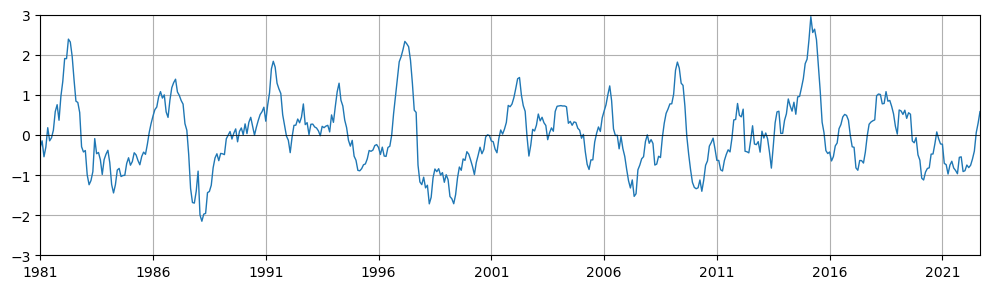

In [16]:
### plot the noisy (unsmoothed) nino3.4 index
# Convert cftime datetime objects to strings, truncate the strings to year only
time_data_str = [str(t)[:4] for t in nino34_index['time'].values]
    
# Convert Nino3.4 index data to numpy array
nino34_unsmooth = nino34_index_unsmooth.values
nino34_data = nino34_index.values

# Create an array for the x-axis
x = np.arange(len(nino34_data))
xn = np.arange(len(nino34_unsmooth))

# plot the unsmoothed timeseries
plt.figure(figsize=(10,3))
plt.plot(xn, nino34_unsmooth, linewidth=1)
plt.grid(True)
plt.xlim(x[0], x[-1])
plt.ylim(-3, 3)
plt.axhline(0, color='black', linewidth=0.5)

# Set x-ticks and x-tick labels
plt.xticks(x[::60], time_data_str[::60])  # Change the step size to adjust the density of x-ticks

# Display the plot
plt.tight_layout()
plt.savefig('nino34unsmoothed.png', dpi=300)

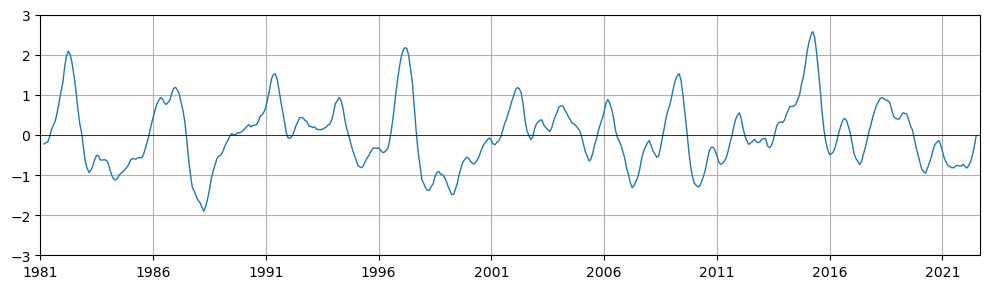

In [17]:
# plot the smoothed timeseries
plt.figure(figsize=(10,3))
plt.plot(x, nino34_data, linewidth=1) # smoothed
plt.grid(True)
plt.xlim(x[0], x[-1])
plt.ylim(-3, 3)
plt.axhline(0, color='black', linewidth=0.5)

# Set x-ticks and x-tick labels
plt.xticks(x[::60], time_data_str[::60])  # Change the step size to adjust the density of x-ticks

# Display the plot
plt.tight_layout()
plt.savefig('nino34smoothed.png', dpi=300)

# Regressing SST onto Nino3.4
Note: you need to have calculated Nino3.4 already to run this section. The first few blocks illustrates what "regressing against Nino3.4" means at one location. Then we repeat this for every location. 

In [49]:
from scipy import stats

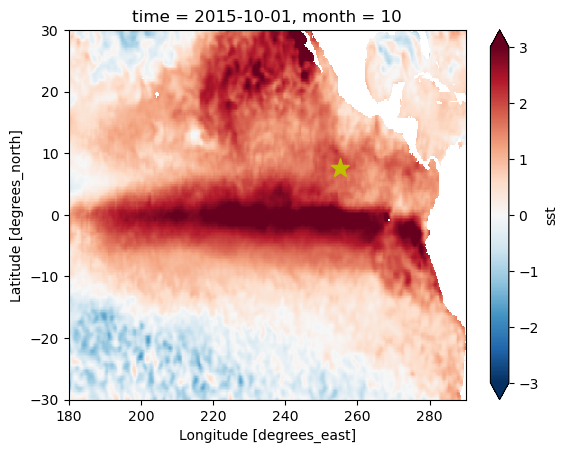

In [35]:
fig, ax = plt.subplots()

# Generate spatial plot of SST anomaly at given time
sst_anom_2015 = ssta.sel(time='2015-10-01', lon=slice(180, 290), lat=slice(-30, 30))
plot = sst_anom_2015.plot(ax=ax, cmap='RdBu_r', vmin=-3, vmax=3, extend='both')

# Mark the location
ax.plot(sst_anom_2015.lon[300], sst_anom_2015.lat[150], 'y*', markersize=14)

plt.savefig('sst_anom_loc.png', dpi=300)

In [38]:
# check location 
sst_anom_2015[150,300]

<xarray.DataArray 'sst' ()>
array(1.9048176, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-10-01
    lat      float32 7.625
    lon      float32 255.1
    month    int64 10

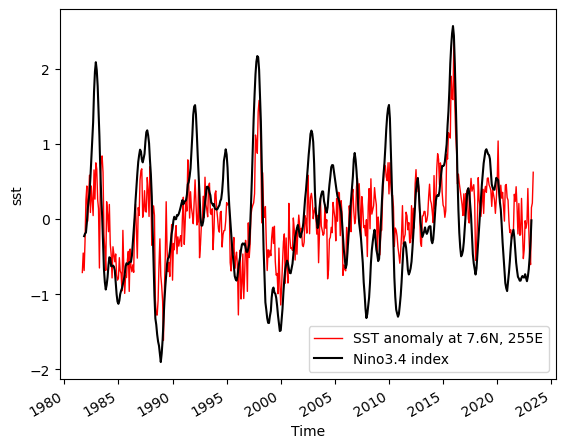

In [61]:
# Extract the time series for the specific location
sst_anom_timeseries = ssta.sel(lat=7.625, lon=255.1, method='nearest')

fig, ax = plt.subplots()

# Generate the plot
sst_anom_timeseries.plot(ax=ax, label='SST anomaly at 7.6N, 255E', color='r', linewidth=1)
nino34_index.plot(ax=ax, label='Nino3.4 index', color='k')

ax.legend()

plt.savefig('sst_nino34_timeseries.png', bbox_inches='tight', dpi=300)

Slope of line of best fit:  0.4301122782419587
P-value of fit:  3.465429145836151e-69


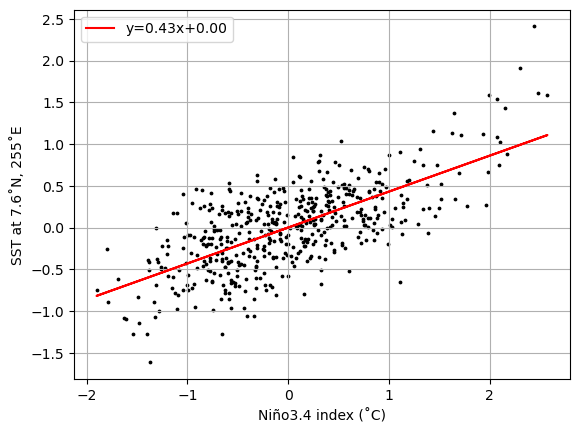

In [62]:
fig, ax = plt.subplots()

# Generate the scatter plot
ax.scatter(nino34_index, sst_anom_timeseries, color='k', s=3)

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(nino34_index[2:-2], sst_anom_timeseries[2:-2])
line = slope * nino34_index + intercept
ax.plot(nino34_index, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))
ax.set_xlabel('Niño3.4 index (˚C)')
ax.set_ylabel('SST at 7.6˚N, 255˚E')
plt.grid(True)
ax.legend()

print('Slope of line of best fit: ', slope)
print('P-value of fit: ', p_value)

plt.savefig('sst_nino34_oneloccorr.png',bbox_inches='tight', dpi=300)

The next operation is a lengthy one, since we are computing nlat * nlon = 720 * 1440 = 1036800 linear regressions! 

In [71]:
def regression_slope_pval(y):
    """Calculate regression slope and p value between y (SST anomaly) and Nino3.4 index"""
    slope, _, _, p_value, _ = stats.linregress(nino34_index[2:-2], y)
    return xr.DataArray([slope, p_value])

# Perform regression at each point in the SST anomaly dataset
from dask.diagnostics import ProgressBar
with ProgressBar():
    result = xr.apply_ufunc(regression_slope_pval, ssta[2:-2,:,:].chunk({'lon': 50, 'lat': 50}),
                            input_core_dims=[['time']],
                            vectorize=True,
                            dask="parallelized",
                            output_core_dims=[['parameter']],
                            output_dtypes=[float],
                            dask_gufunc_kwargs={'parameter': 2}).compute()

result['parameter'] = ['slope', 'p_value']

# Separate the results into two datasets for easy access
slopes = result.sel(parameter='slope')
p_values = result.sel(parameter='p_value')


[                                        ] | 0% Completed | 124.81 ms

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_4052/3926434529.py:9: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(regression_slope_pval, ssta[2:-2,:,:].chunk({'lon': 50, 'lat': 50}),


[########################################] | 100% Completed | 465.06 s


In [77]:
# save the slopes/pvalues locally
slopes.to_netcdf('sst_nino34_reg.nc')
p_values.to_netcdf('sst_nino34_regpval.nc')

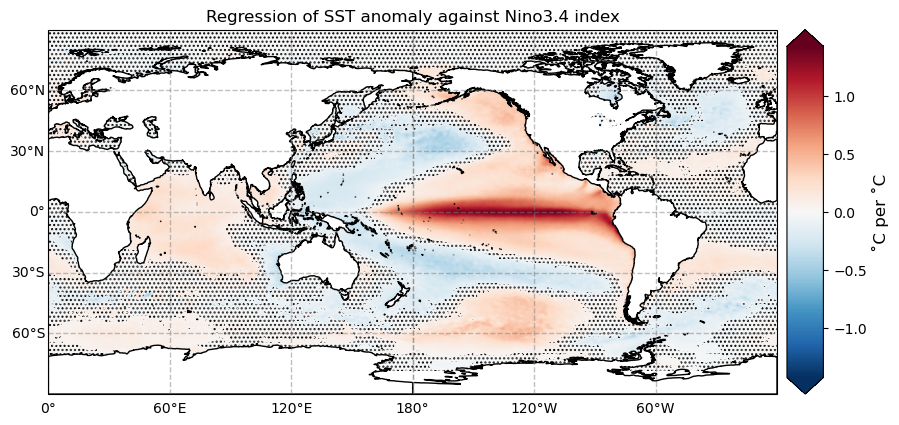

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and set the projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
land_feature = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor='none', edgecolor='black')
ax.add_feature(land_feature)

# Set the map extent to cover the Pacific
ax.set_extent([-90, 270, -90, 90], crs=ccrs.PlateCarree())

# Generate contour plot of slopes
cplot = slopes.plot(ax=ax, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

# Add hatching to areas where p value exceeds 0.01
p_values.where(p_values > 0.01).plot.contourf(ax=ax, colors='none', hatches=['....'], add_colorbar=False, transform=ccrs.PlateCarree())

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create an axes divider
divider = make_axes_locatable(ax)

# Define the size and pad of the colorbar
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

# Add a colorbar with custom label and scaled height
cbar = plt.colorbar(cplot, cax=cax, ax=ax, extend='both', fraction=0.5)
cbar.set_label('˚C per ˚C', size=12)

# Set title and axis labels
ax.set_title("Regression of SST anomaly against Nino3.4 index")
ax.set_xlabel("Longitude (˚E)")
ax.set_ylabel("Latitude (˚N)")

plt.savefig('SST_nino34_regression.png', dpi=300, bbox_inches='tight')

# EOF/PCA 


Variance in x direction for the original data: 3.0224846122756697
Variance in x direction for the transformed data: 3.8669138304627624


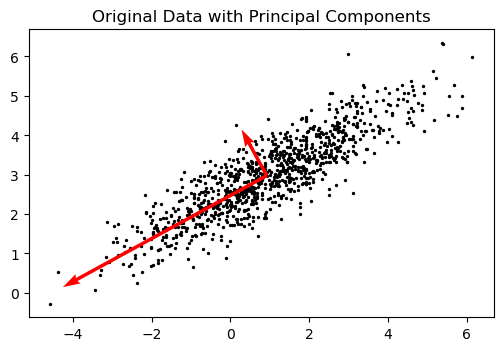

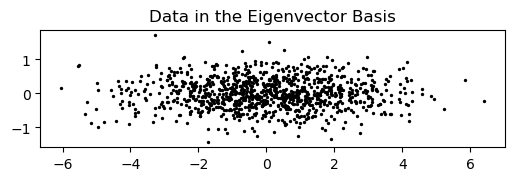

In [105]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

rng = np.random.RandomState(1)
C = np.array([[3.0, 1.5], [1.5, 1.0]])
mu = np.array([1.0, 3.0])

# Generate samples
samples = rng.multivariate_normal(mu, C, 1000)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(samples)
components = pca.components_
mean = pca.mean_

# Scatter plot of original data with principal components
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=2, color='k')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)  # Adjust the length of eigenvectors
    plt.quiver(mean[0], mean[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color=['r', 'g'])
plt.gca().set_aspect('equal', 'box')
plt.title('Original Data with Principal Components')
plt.savefig("2D_gaussian_data_pca.png", bbox_inches='tight', dpi=300)

# Scatter plot of data in the eigenvector basis
samples_pca = pca.transform(samples)
plt.figure(figsize=(6, 6))
plt.scatter(samples_pca[:, 0], samples_pca[:, 1], s=2, color='k')
plt.gca().set_aspect('equal', 'box')
plt.title('Data in the Eigenvector Basis')
plt.savefig('2D_gaussian_transformed.png', bbox_inches='tight', dpi=300)

# Variance in x direction for the original data
var_original = np.var(samples[:, 0])

# Variance in x direction for the transformed data
var_transformed = np.var(samples_pca[:, 0])

print(f'Variance in x direction for the original data: {var_original}')
print(f'Variance in x direction for the transformed data: {var_transformed}')

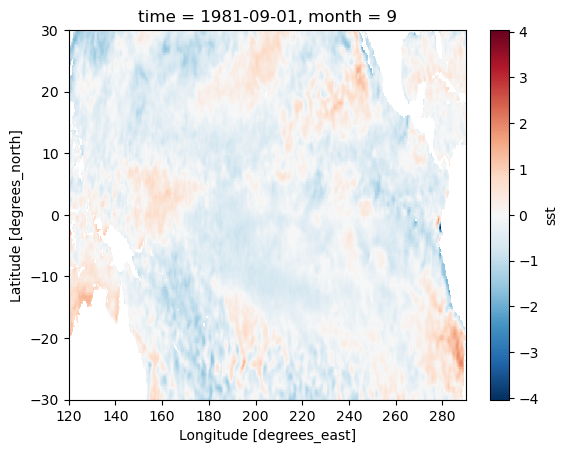

In [6]:
# select entire equatorial Pacific 
ssta_pcf = ssta.sel(lon=slice(120,290), lat=slice(-30,30))
ssta_pcf[0,:,:].plot()

In [8]:
from eofs.standard import Eof

# Convert the DataArray to a numpy array
ssta_pcf_np = ssta_pcf.values

# Create an EOF solver to do the EOF analysis. Square-root of cosine of latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(ssta_pcf.lat.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ssta_pcf_np, weights=wgts)

# Retrieve the leading EOFs, expressed as the correlation between the leading PC time series and the input SST anomalies at each grid point, and the
# leading PC time series themselves.
eofs = solver.eofsAsCorrelation(neofs=4)
pcs = solver.pcs(npcs=4, pcscaling=1)

# Get the explained variance fraction
variance_frac = solver.varianceFraction(neigs=4)

# Print the explained variance fraction for each EOF.
for i in range(4):
    print('EOF {0} explains {1:.2f} of the total variance.'.format(i+1, variance_frac[i]*100))


EOF 1 explains 30.08 of the total variance.
EOF 2 explains 13.32 of the total variance.
EOF 3 explains 7.77 of the total variance.
EOF 4 explains 3.71 of the total variance.


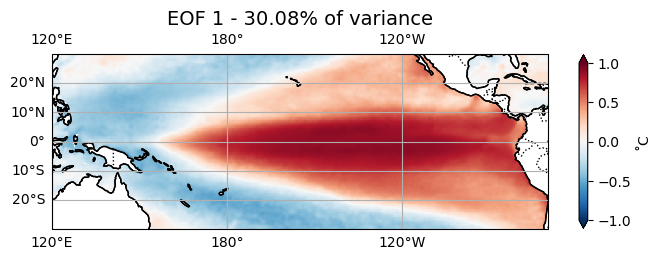

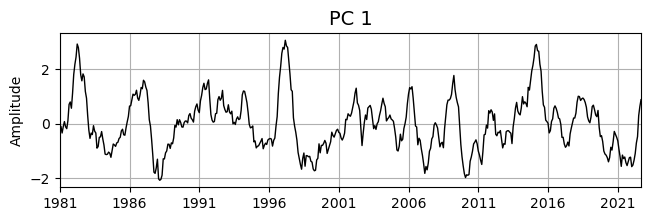

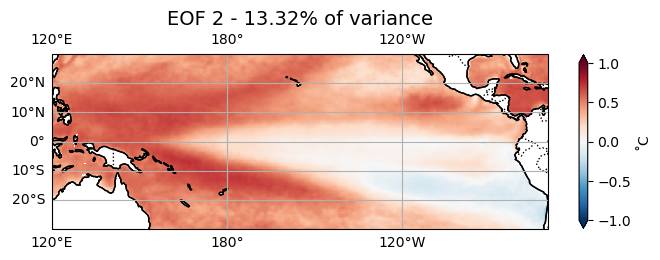

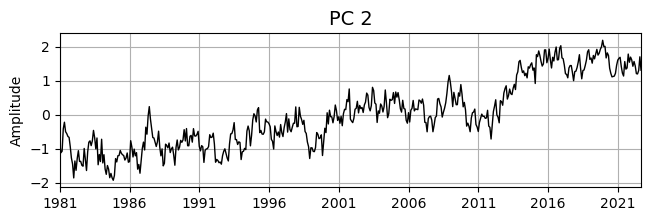

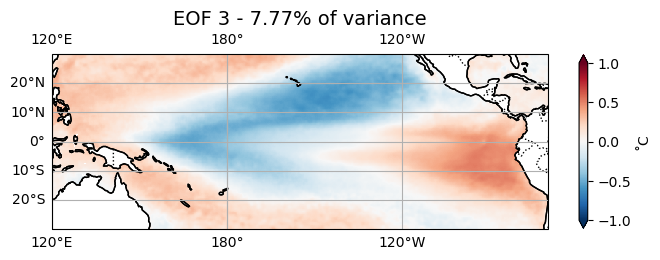

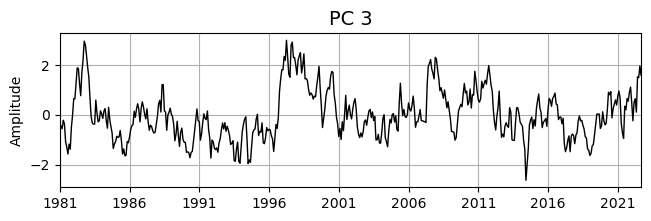

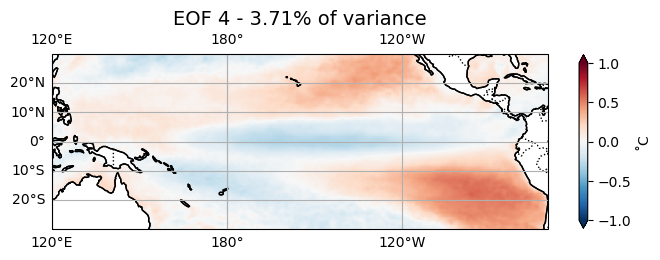

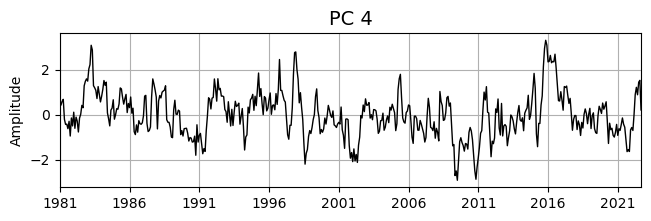

In [63]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Specify projection
projection = ccrs.PlateCarree(central_longitude=180)
lat = ssta.lat.sel(lat=slice(-30,30))
lon = ssta.lon.sel(lon=slice(120,290))

# Loop through each EOF and PC
for i in range(4):
    # Create a figure for the EOF
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': projection})
    eof = eofs[i]  # Select the EOF
    eof_abs_max = 1

    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Plot EOF
    plot = ax.pcolormesh(lon, lat, eof, vmin=-eof_abs_max, 
                       vmax=eof_abs_max, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    ax.set_title(f"EOF {i+1} - {variance_frac[i]*100:.2f}% of variance", fontsize=14)
    ax.set_xlabel('Longitude (˚E)')
    ax.set_ylabel('Latitude (˚N)')
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    
    # Add colorbar
    cbar = plt.colorbar(plot, ax=ax, shrink=0.45, extend='both')
    cbar.set_label("˚C")

    plt.savefig(f'Pcfsst_EOF{i+1}.png', bbox_inches='tight', dpi=300)  
    
    # Create a separate figure for the PC
    fig, ax = plt.subplots(figsize=(7.5, 2))
    pc = pcs[:, i]  # Select the corresponding PC
    
    # Plot PC
    x = np.arange(len(pcs[:,0]))
    ax.plot(pc, linewidth=1, color='k')
    ax.set_xticks(x[::60], time_data_str[::60])
    ax.set_xlim(x[0], x[-1])
    ax.grid(True)
    ax.set_title(f"PC {i+1}", fontsize=14)
    ax.set_ylabel('Amplitude')
    
    plt.savefig(f'Pcfsst_PC{i+1}.png', bbox_inches='tight', dpi=300)  


# Lorenz attractor animation
Modified after https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/


<IPython.core.display.Javascript object>


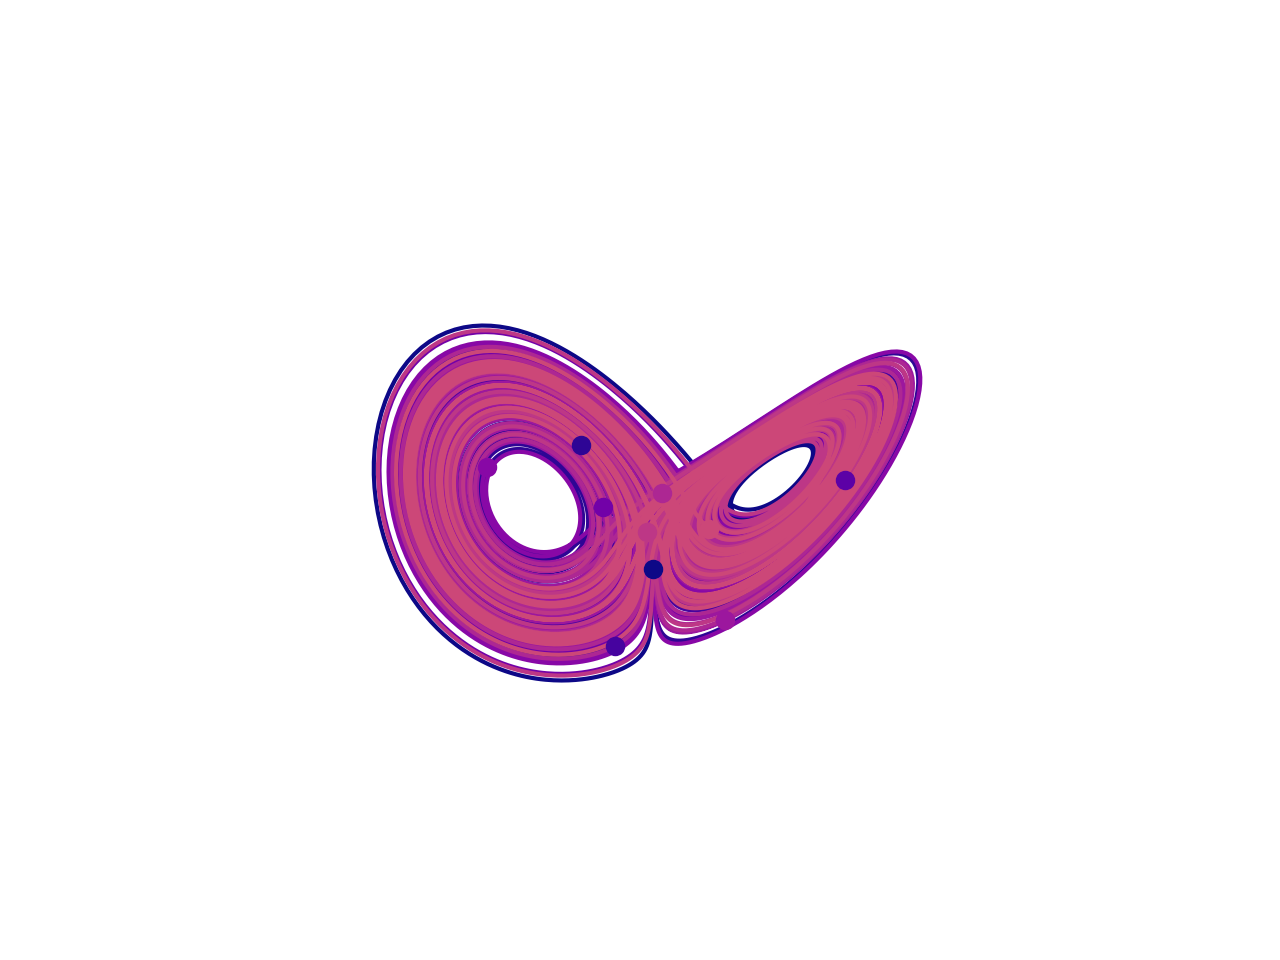

In [18]:
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

# enable animation within Jupyter notebook
%matplotlib notebook

N_trajectories = 10

def lorentz_deriv(xyz, t0, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorentz system."""
    x, y, z = xyz
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Define three very close initial points
x0 = np.array([
    [-10, -10, 20],
    [-10.001, -10, 20],
    [-10.002, -10, 20],
    [-10.003, -10, 20],
    [-10.004, -10, 20],
    [-10.005, -10, 20],
    [-10.006, -10, 20],
    [-10.007, -10, 20],
    [-10.008, -10, 20],
    [-10.009, -10, 20],
])

# Solve for the trajectories
t = np.linspace(0, 40, 10000)
x_t = np.asarray([integrate.odeint(lorentz_deriv, x0i, t)
                  for x0i in x0])

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.plasma(np.linspace(0, 0.5, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    #fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=30, blit=True)

# Save as mp4. This requires mplayer or ffmpeg to be installed
anim.save('lorentz_attractor.mp4', fps=60, extra_args=['-vcodec', 'libx264'], dpi=300)

plt.show()
